# Customer Survival Analysis - Bank Churn Dataset

This notebook performs survival analysis to understand time-to-churn patterns
and identify which customer segments have significantly different retention rates.

**Key Questions:**
- How long do customers typically stay with the bank before churning?
- Which customer segments have significantly different survival curves?
- What are the hazard ratios for different features?
- Can we predict individual customer lifetime?

## Theory: Survival Analysis Fundamentals

If time to event has the probability density function $f(t)$ and cumulative distribution function $F(t)$, 
then the probability of surviving at least to time $t$ is: 

$$S(t) = Pr(T>t) = 1-F(t)$$

**Cumulative hazard** at time $t$ is defined as:

$$H(t)=-\ln(S(t))$$

**Instantaneous hazard** at time $t$ is:

$$h(t)=\frac{dH(t)}{dt} = \frac{f(t)}{S(t)}$$

### Likelihood Function for Survival Analysis

$$ \mathcal{L}(\beta) = \prod_{i=1}^{n} h(t_{i})^{d_{i}} S(t_{i}) $$

where:
- $d_i$ = censoring variable (1 if event observed, 0 if censored)
- $h(t_i)$ = hazard for individual $i$ at time $t$
- $S(t_i)$ = survival probability for individual $i$ at time $t$

The **log-likelihood** is:

$$ \log\mathcal{L}(\beta) = \sum_{i=1}^n d_i \log(h(t_i)) - H(t_i) $$

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm

# Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

# Import custom plotting functions
from survival_utils import (
    plot_survival_analysis_2groups,
    plot_survival_analysis_multigroup,
    prepare_survival_data
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## Data Preparation

In [2]:
# Load data
df = pd.read_csv("data/Customer-Churn-Records.csv")
print(f"Data shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()

Data shape: (10000, 18)

Data types:
RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

First few rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### Data Preprocessing

In [3]:
# Drop identifier columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Standardize column names
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]

# Convert binary columns to int (0/1)
bin_cols = ['hascrcard', 'isactivemember', 'exited', 'complain']
for col in bin_cols:
    df[col] = df[col].astype(int)

# Encode gender: Male=0, Female=1
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Create age groups (based on EDA findings)
df['age_group'] = pd.cut(df['age'], 
                          bins=[0, 30, 40, 50, 60, 70, 100],
                          labels=['18-30', '31-40', '41-50', '51-60', '61-70', '70+'])

# Create balance groups
df['balance_group'] = pd.cut(df['balance'],
                              bins=[-1, 0, 50000, 100000, 150000, 300000],
                              labels=['Zero', 'Low', 'Medium', 'High', 'Very High'])

# Create tenure groups
df['tenure_group'] = pd.cut(df['tenure'],
                             bins=[0, 2, 4, 6, 8, 11],
                             labels=['0-2', '3-4', '5-6', '7-8', '9-10'])

print(f"✓ Data preprocessed. Shape: {df.shape}")
print(f"\nFeatures: {list(df.columns)}")

✓ Data preprocessed. Shape: (10000, 18)

Features: ['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited', 'complain', 'satisfaction_score', 'card_type', 'point_earned', 'age_group', 'balance_group', 'tenure_group']


In [4]:
# Define event and time variables for survival analysis
eventvar = df['exited']  # Churn indicator (0 = retained, 1 = churned)
timevar = df['tenure']   # Time customer remained with bank (in years)

print(f"Event variable (exited): {eventvar.value_counts().to_dict()}")
print(f"Time variable (tenure) - range: {timevar.min()} to {timevar.max()} years")
print(f"Time variable (tenure) - mean: {timevar.mean():.2f} years")

Event variable (exited): {0: 7962, 1: 2038}
Time variable (tenure) - range: 0 to 10 years
Time variable (tenure) - mean: 5.01 years


---

## Overall Kaplan-Meier Survival Curve

The Kaplan-Meier estimator provides a non-parametric estimate of the survival function.
This shows the probability that a customer will remain with the bank beyond time $t$.

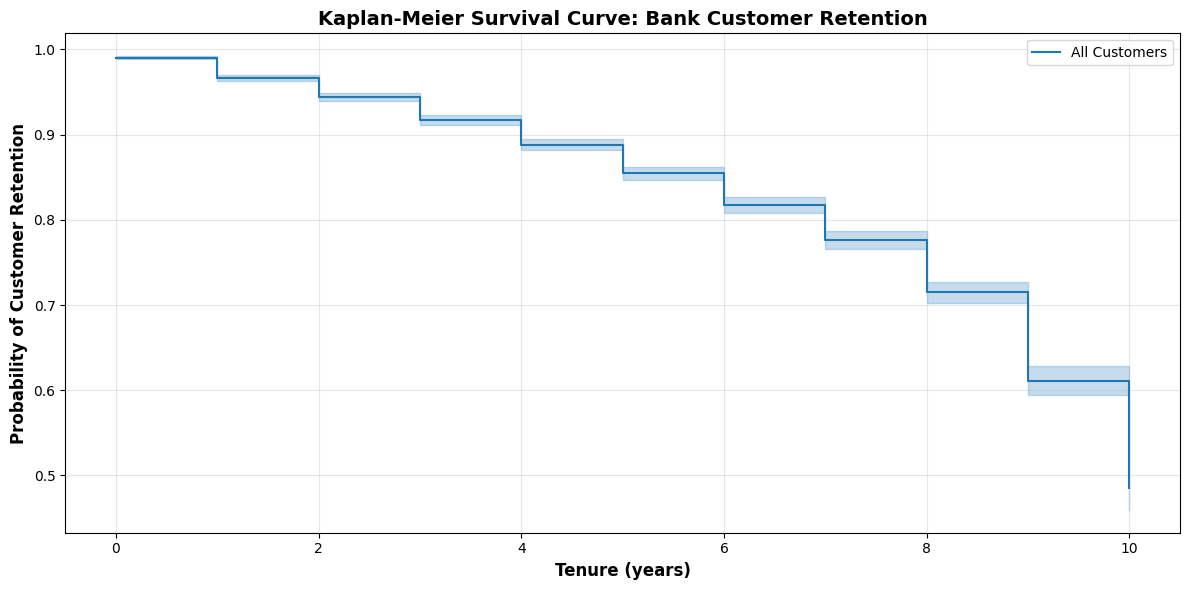

Median survival time: 10.00 years


In [5]:
# Create a Kaplan-Meier object
kmf = KaplanMeierFitter()

# Calculate the K-M curve for all customers
kmf.fit(timevar, event_observed=eventvar, label="All Customers")

# Plot the curve
fig, ax = plt.subplots(figsize=(12, 6))
kmf.plot(ax=ax, ci_show=True)
ax.set_ylabel('Probability of Customer Retention', fontsize=12, fontweight='bold')
ax.set_xlabel('Tenure (years)', fontsize=12, fontweight='bold')
ax.set_title('Kaplan-Meier Survival Curve: Bank Customer Retention', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Median survival time: {kmf.median_survival_time_:.2f} years")

### Interpretation

The K-M curve shows how customer retention probability changes over time. 
A steeper decline indicates periods of higher churn risk. The median survival time 
tells us when 50% of customers are expected to have churned.

---

## Log-Rank Test Theory

### Statistical Framework

The **log-rank test** is a non-parametric method to compare survival curves between groups.
It assumes proportional hazards and tests the null hypothesis that survival probabilities 
are the same across groups at all time points.

**Test statistic** for group $j$:

$$k_{j} = \frac{(O_{j}-E_{j})^{2}}{var(O_{j}-E_{j})}$$

where:
- $O_{j}$ = observed events in group $j$
- $E_{j}$ = expected events in group $j$ under null hypothesis
- $var(O_{j}-E_{j})$ = variance of the difference

The observed minus expected for group $j$:

$$O_{j}-E_{j} = \sum_{i}(o_{ij}-e_{ij})$$

The variance:

$$var(O_{j}-E_{j}) = \sum_i o_{i}\frac{n_{ij}}{n_{i}}\Big(1-\frac{n_{ij}}{n_{i}}\Big)\frac{(n_{i}-o_{i})}{(n_{i}-1)}$$

For **multiple groups**, the test statistic is:

$$\chi^2 = \mathbf{Z} \Sigma^{-1} \mathbf{Z}'$$

which follows a $\chi^2$ distribution with $k-1$ degrees of freedom, where $k$ is the number of groups.

---

## Group Comparisons with Log-Rank Tests

Based on our EDA findings, we'll compare survival curves for the features that showed 
significant differences in churn rates:

**Priority features from EDA:**
1. Complain (99.5% churn for complainers - strongest predictor)
2. Age Group (lifecycle pattern: 51-60 has 56% churn)
3. IsActiveMember (1.9× difference: 27% vs 14%)
4. NumOfProducts (U-shape: 7.6% for 2 products, 100% for 4)
5. Geography (Germany 32% vs France/Spain 16%)

### 1. Complain Status

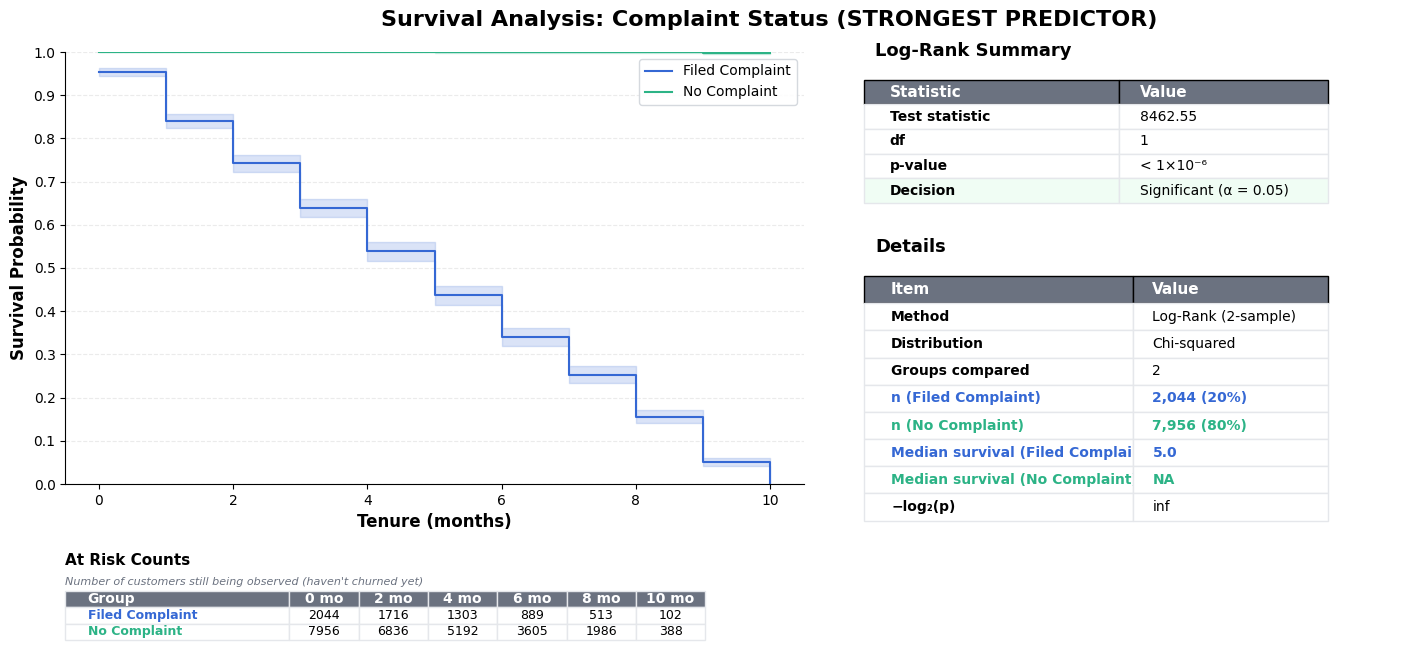

In [6]:
# From EDA: THE strongest predictor (0.996 correlation)
complain_mask = (df['complain'] == 1)
no_complain_mask = (df['complain'] == 0)

result_complain = plot_survival_analysis_2groups(
    timevar, eventvar, complain_mask, no_complain_mask,
    "Filed Complaint", "No Complaint",
    "Survival Analysis: Complaint Status (STRONGEST PREDICTOR)",
    kmf,
    show_at_risk=True
)

**Insight:** Customers who file complaints have catastrophically poor retention.
This is the single most important red flag for churn prediction.

### 2. Active Member Status

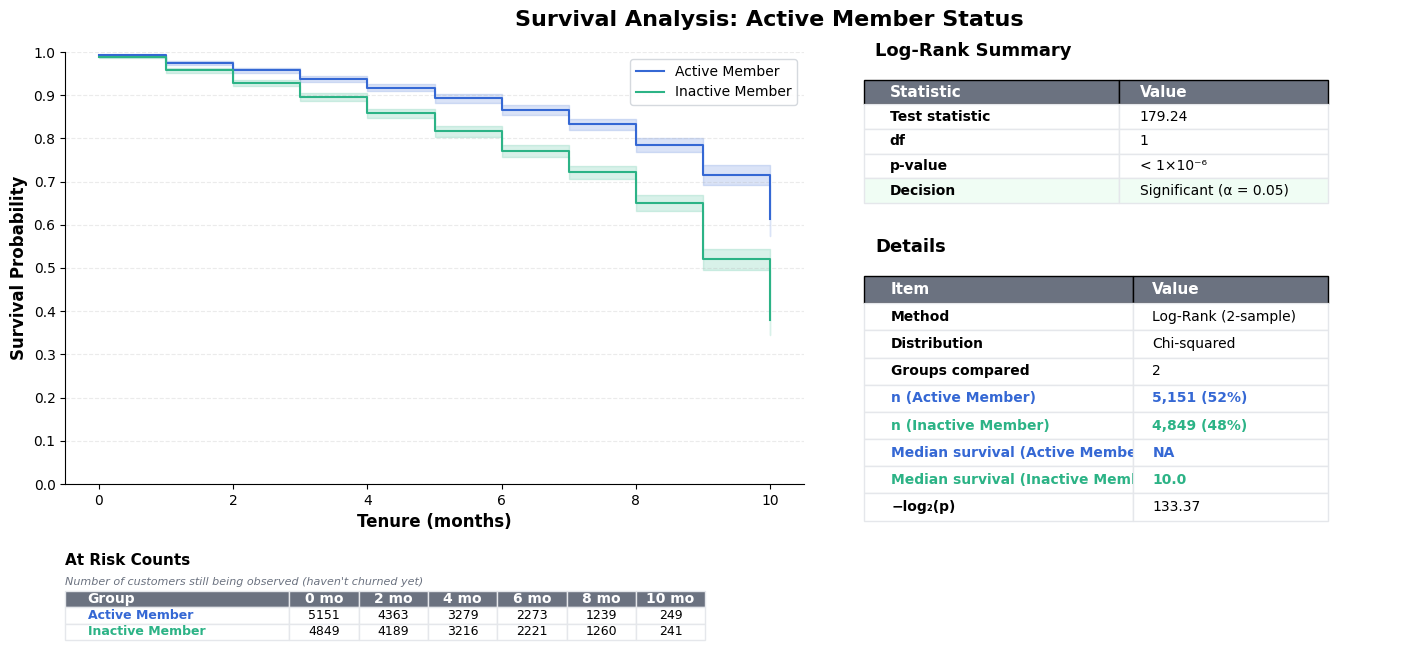

In [7]:
# From EDA: Strong behavioral predictor (-0.156 correlation)
active_mask = (df['isactivemember'] == 1)
inactive_mask = (df['isactivemember'] == 0)

result_active = plot_survival_analysis_2groups(
    timevar, eventvar, active_mask, inactive_mask,
    "Active Member", "Inactive Member",
    "Survival Analysis: Active Member Status",
    kmf,
    show_at_risk=True
)

**Insight:** Inactive members show significantly lower retention. 
Re-activation campaigns should target this segment.

### 3. Age Group

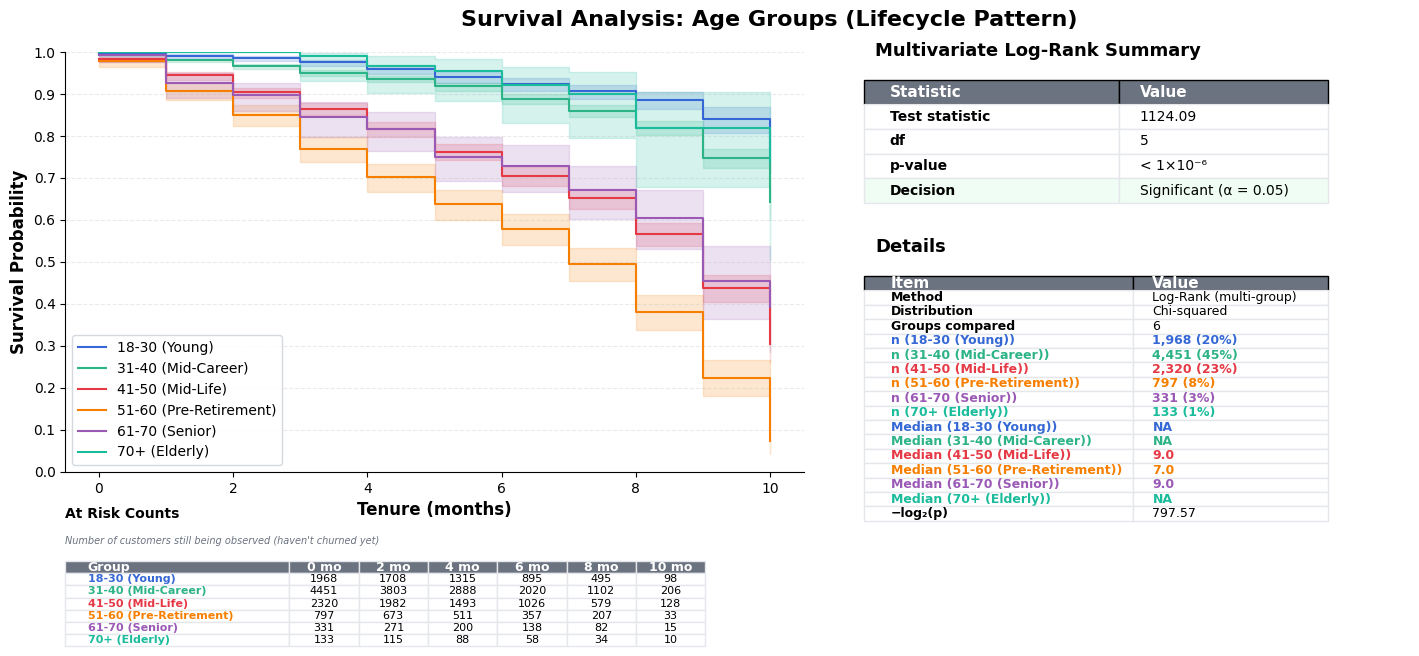

In [8]:
# From EDA: Strong demographic predictor with clear lifecycle pattern
# Create masks for each age group
age_18_30 = (df['age_group'] == '18-30')
age_31_40 = (df['age_group'] == '31-40')
age_41_50 = (df['age_group'] == '41-50')
age_51_60 = (df['age_group'] == '51-60')
age_61_70 = (df['age_group'] == '61-70')
age_70_plus = (df['age_group'] == '70+')

result_age = plot_survival_analysis_multigroup(
    timevar, eventvar, df, 'age_group',
    [age_18_30, age_31_40, age_41_50, age_51_60, age_61_70, age_70_plus],
    ["18-30 (Young)", "31-40 (Mid-Career)", "41-50 (Mid-Life)", 
     "51-60 (Pre-Retirement)", "61-70 (Senior)", "70+ (Elderly)"],
    "Survival Analysis: Age Groups (Lifecycle Pattern)",
    kmf,
    show_at_risk=True
)

**Insight:** The 51-60 age group (pre-retirement) shows dramatically lower retention.
This segment likely moves assets for retirement planning and requires specialized retention strategies.

### 4. Number of Products

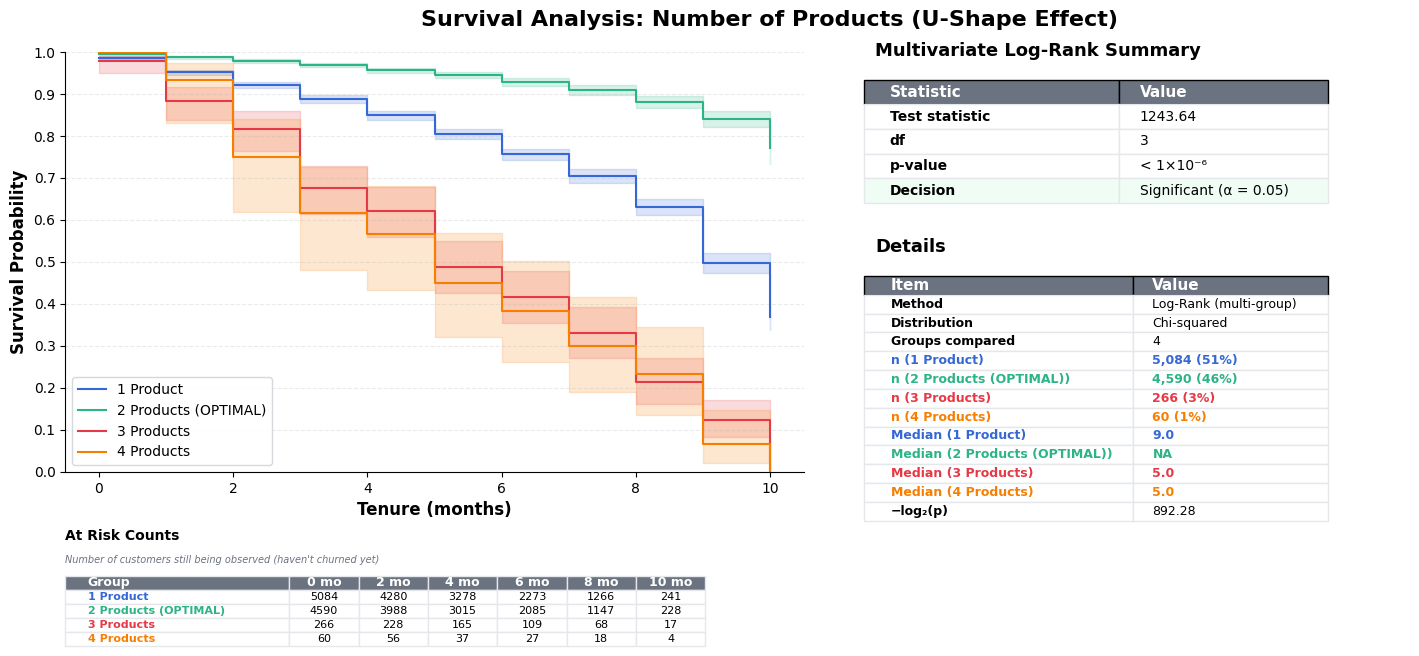

In [9]:
# From EDA: Strong non-linear predictor (U-shape with 2 products optimal)
prod_1 = (df['numofproducts'] == 1)
prod_2 = (df['numofproducts'] == 2)
prod_3 = (df['numofproducts'] == 3)
prod_4 = (df['numofproducts'] == 4)

result_products = plot_survival_analysis_multigroup(
    timevar, eventvar, df, 'numofproducts',
    [prod_1, prod_2, prod_3, prod_4],
    ["1 Product", "2 Products (OPTIMAL)", "3 Products", "4 Products"],
    "Survival Analysis: Number of Products (U-Shape Effect)",
    kmf,
    show_at_risk=True
)

**Insight:** Customers with 2 products have the best retention (7.6% churn).
Those with 3-4 products have catastrophic churn - likely over-selling backfires.

### 5. Geography

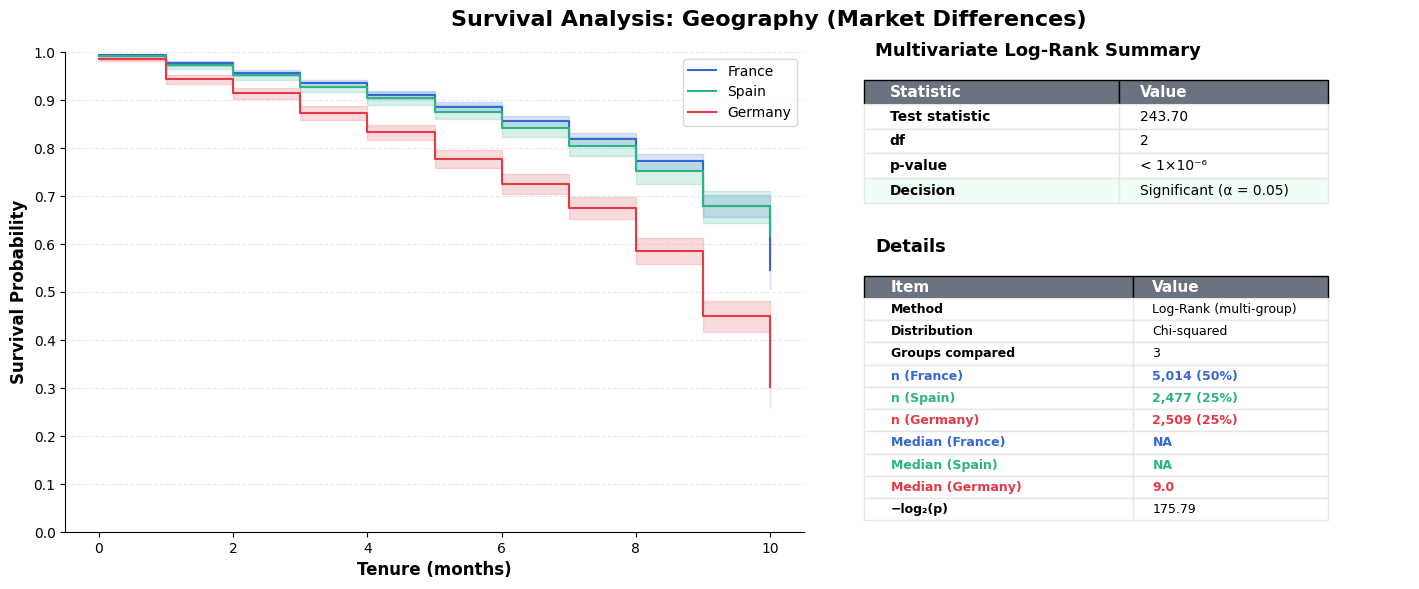

In [10]:
# From EDA: Strong geographic effect (Germany 2× higher churn)
france_mask = (df['geography'] == 'France')
spain_mask = (df['geography'] == 'Spain')
germany_mask = (df['geography'] == 'Germany')

result_geo = plot_survival_analysis_multigroup(
    timevar, eventvar, df, 'geography',
    [france_mask, spain_mask, germany_mask],
    ["France", "Spain", "Germany"],
    "Survival Analysis: Geography (Market Differences)",
    kmf
)

**Insight:** Germany shows significantly lower retention than France/Spain.
This suggests market-specific issues requiring investigation.

### 6. Gender

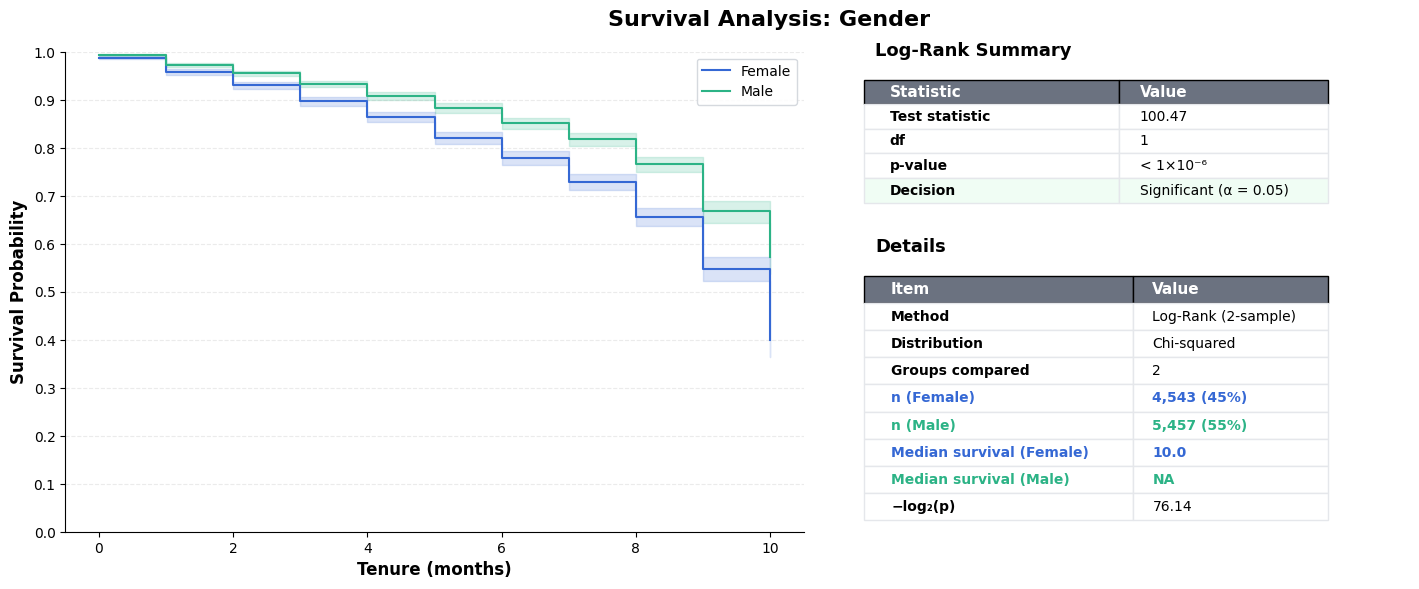

In [11]:
# From EDA: Moderate demographic effect (1.5× difference)
female_mask = (df['gender'] == 1)
male_mask = (df['gender'] == 0)

result_gender = plot_survival_analysis_2groups(
    timevar, eventvar, female_mask, male_mask,
    "Female", "Male",
    "Survival Analysis: Gender",
    kmf
)

**Insight:** Females show moderately higher churn than males.

### 7. Balance Group (Zero vs Non-Zero)

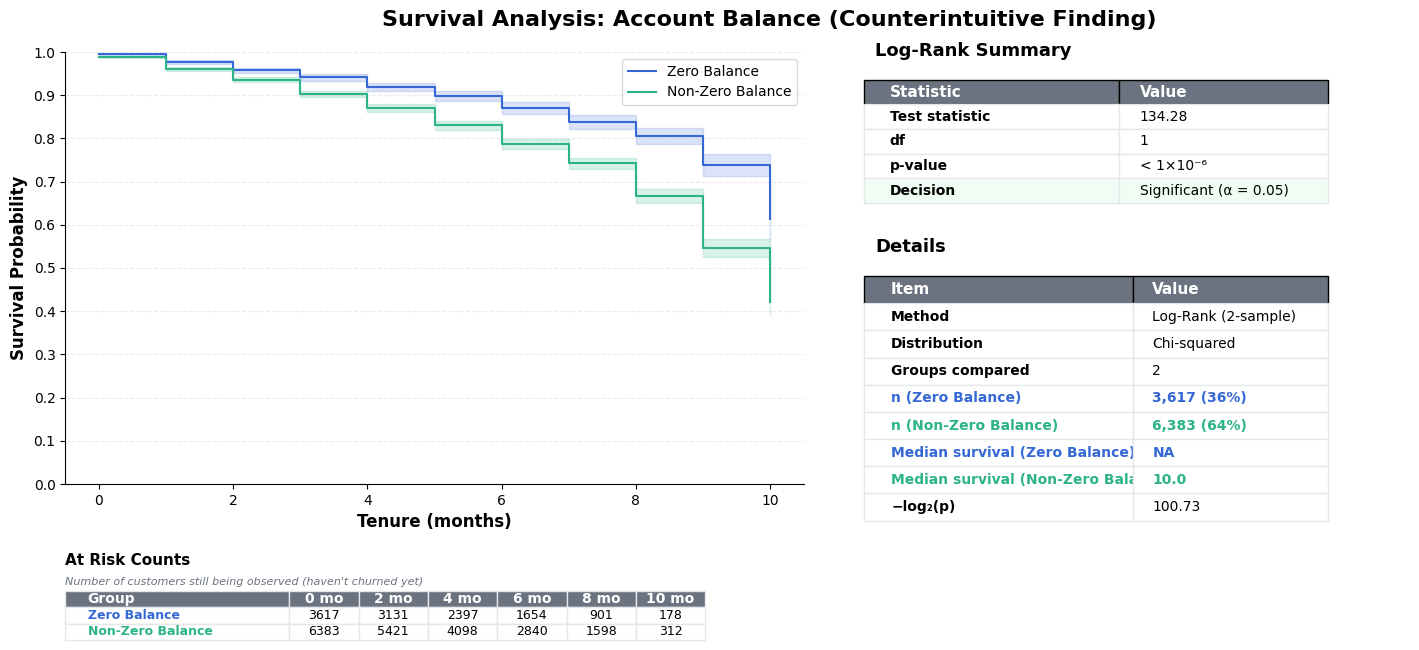

In [12]:
# From EDA: Counterintuitive finding - zero balance has LOWER churn
zero_balance = (df['balance'] == 0)
nonzero_balance = (df['balance'] > 0)

result_balance = plot_survival_analysis_2groups(
    timevar, eventvar, zero_balance, nonzero_balance,
    "Zero Balance", "Non-Zero Balance",
    "Survival Analysis: Account Balance (Counterintuitive Finding)",
    kmf,
    show_at_risk=True
)

**Insight:** Zero-balance accounts actually have BETTER retention (13.8% vs 24.1% churn).
These may be "parking" accounts customers intentionally maintain.

---

## Cox Proportional Hazards Model

### Theory

The Cox PH model is a semi-parametric regression model that estimates the hazard ratio 
for each predictor while leaving the baseline hazard unspecified:

$$h(t|X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p)$$

where:
- $h(t|X)$ = hazard at time $t$ given covariates $X$
- $h_0(t)$ = baseline hazard function
- $\beta$ = coefficients (log hazard ratios)
- $\exp(\beta_i)$ = hazard ratio for feature $i$

**Hazard Ratio Interpretation:**
- HR > 1: Feature increases churn risk
- HR < 1: Feature decreases churn risk (protective)
- HR = 1: No effect

### Data Preparation for Cox PH Model

**Feature Selection Strategy:**

**Dropped 6 weak features** (from EDA Section 9):
- ❌ `card_type` - No predictive value (1.1× difference)
- ❌ `hascrcard` - No predictive value (1.0× difference)
- ❌ `satisfaction_score` - No predictive value (1.1× difference)
- ❌ `point_earned` - No predictive value (-0.005 correlation)
- ❌ `estimatedsalary` - No predictive value (0.012 correlation)
- ❌ `creditscore` - No predictive value (-0.027 correlation)

**Dropped 2 problematic features** (for Cox PH model):
- ❌ `age` - Multicollinearity with `age_group` (both measure the same thing)
- ❌ `complain` - Too dominant (exp(coef) = 2,652×, 99.5% churn rate)
  - Complaint status drowns out all other features
  - We already know from log-rank tests that complain is THE strongest predictor
  - Removing it lets us see the effects of other features

**Final feature set:** 6 core features + age_group categories
- ✅ Gender, tenure, balance, numofproducts, isactivemember, geography, age_group

In [13]:
# Prepare data for regression
regression_df = df.copy()

# Drop weak/useless features identified in EDA
weak_features = ['card_type', 'hascrcard', 'satisfaction_score', 
                 'point_earned', 'estimatedsalary', 'creditscore']
regression_df = regression_df.drop(weak_features, axis=1)
print(f"✓ Dropped {len(weak_features)} weak features: {weak_features}")

# Drop features that cause issues in Cox PH model
# 1. Drop 'age' to avoid multicollinearity with age_group
# 2. Drop 'complain' because it dominates all other effects (exp(coef) = 2,652×)
problematic_features = ['age', 'complain']
regression_df = regression_df.drop(problematic_features, axis=1)
print(f"✓ Dropped {len(problematic_features)} problematic features for Cox model: {problematic_features}")
print("  - age: Multicollinearity with age_group_*")
print("  - complain: Too dominant (99.5% churn rate), drowns out other features")

# Create dummy variables for categorical features (only the useful ones)
categorical_cols = ['geography', 'age_group']
regression_df = pd.get_dummies(regression_df, columns=categorical_cols, drop_first=True, dtype=int)

# Drop grouped versions (already have continuous versions)
drop_cols = ['balance_group', 'tenure_group']
regression_df = regression_df.drop(drop_cols, axis=1)

print(f"\nRegression data shape: {regression_df.shape}")
print(f"Columns ({len(regression_df.columns)}): {list(regression_df.columns)}")
print(f"\n✓ Cox PH Model will use 6 core features:")
print("  - isactivemember, numofproducts, geography, balance, gender, tenure, age_group")
print(f"\nNote: Run separate analysis if you want to see 'complain' effect (it's THE dominant predictor)")
regression_df.head()

✓ Dropped 6 weak features: ['card_type', 'hascrcard', 'satisfaction_score', 'point_earned', 'estimatedsalary', 'creditscore']
✓ Dropped 2 problematic features for Cox model: ['age', 'complain']
  - age: Multicollinearity with age_group_*
  - complain: Too dominant (99.5% churn rate), drowns out other features

Regression data shape: (10000, 13)
Columns (13): ['gender', 'tenure', 'balance', 'numofproducts', 'isactivemember', 'exited', 'geography_Germany', 'geography_Spain', 'age_group_31-40', 'age_group_41-50', 'age_group_51-60', 'age_group_61-70', 'age_group_70+']

✓ Cox PH Model will use 6 core features:
  - isactivemember, numofproducts, geography, balance, gender, tenure, age_group

Note: Run separate analysis if you want to see 'complain' effect (it's THE dominant predictor)


,gender,tenure,balance,numofproducts,isactivemember,exited,geography_Germany,geography_Spain,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_70+
0,1,2,0.00,1,1,1,0,0,0,1,0,0,0
1,1,1,83807.86,1,1,0,0,1,0,1,0,0,0
2,1,8,159660.80,3,0,1,0,0,0,1,0,0,0
3,1,1,0.00,2,0,0,0,0,1,0,0,0,0
4,1,2,125510.82,1,1,0,0,1,0,1,0,0,0


### Fit Cox PH Model

In [14]:
# Initialize Cox PH fitter
cph = CoxPHFitter()

# Fit model (using tenure as duration and exited as event)
cph.fit(regression_df, duration_col='tenure', event_col='exited')

# Print summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10000 total observations, 7962 right-censored observations>
             duration col = 'tenure'
                event col = 'exited'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 2038
   partial log-likelihood = -16338.28
         time fit was run = 2025-10-23 00:55:33 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
gender             0.38      1.47      0.04            0.30            0.47                1.34                1.60
balance            0.00      1.00      0.00            0.00            0.00                1.00                1.00
numofproducts     -0.08      0.92      0.04           -0.15           -0.01                0.86                0.99
isactivemember    -0.62      0.54      0.05           -0.71           -0.53                0.49                0.59
geography_Germany  0.47      1.60      0.05            0.36            0.58                1.44                1.78
geography_Spain    0.05      1.05      0.06           -0.07            0.17                0.94                1.19
age_group_31-40    0.48      1.61      0.09            0.29            0.66                1.34                1.93
age_group_41-50    1.46      4.31      0.09            1.28            1.64                3.61                5.14
age_group_51-60    2.07      7.94      0.10            1.89            2.26                6.59                9.57
age_group_61-70    1.63      5.12      0.13            1.38            1.89                3.98                6.59
age_group_70+      0.26      1.30      0.31           -0.35            0.88                0.71                2.41

                   cmp to      z      p  -log2(p)
covariate                                        
gender               0.00   8.56 <0.005     56.32
balance              0.00   3.91 <0.005     13.41
numofproducts        0.00  -2.11   0.04      4.83
isactivemember       0.00 -13.24 <0.005    130.49
geography_Germany    0.00   8.63 <0.005     57.24
geography_Spain      0.00   0.88   0.38      1.40
age_group_31-40      0.00   5.12 <0.005     21.64
age_group_41-50      0.00  16.28 <0.005    195.43
age_group_51-60      0.00  21.77 <0.005    346.78
age_group_61-70      0.00  12.69 <0.005    120.11
age_group_70+        0.00   0.85   0.40      1.33
---
Concordance = 0.74
Partial AIC = 32698.56
log-likelihood ratio test = 1457.95 on 11 df
-log2(p) of ll-ratio test = 1014.60

In [15]:
# Model performance: Concordance Index (C-index)
# C-index = 1.0: Perfect predictions
# C-index = 0.5: Random predictions
print(f"\n{'='*80}")
print(f"MODEL PERFORMANCE")
print(f"{'='*80}")
print(f"Concordance Index (C-index): {cph.concordance_index_:.4f}")
print(f"\nInterpretation:")
if cph.concordance_index_ >= 0.8:
    print("✓ Excellent predictive power (C-index ≥ 0.8)")
elif cph.concordance_index_ >= 0.7:
    print("✓ Good predictive power (0.7 ≤ C-index < 0.8)")
elif cph.concordance_index_ >= 0.6:
    print("○ Moderate predictive power (0.6 ≤ C-index < 0.7)")
else:
    print("✗ Weak predictive power (C-index < 0.6)")
print(f"{'='*80}")


MODEL PERFORMANCE
Concordance Index (C-index): 0.7369

Interpretation:
✓ Good predictive power (0.7 ≤ C-index < 0.8)


### Visualize Feature Coefficients

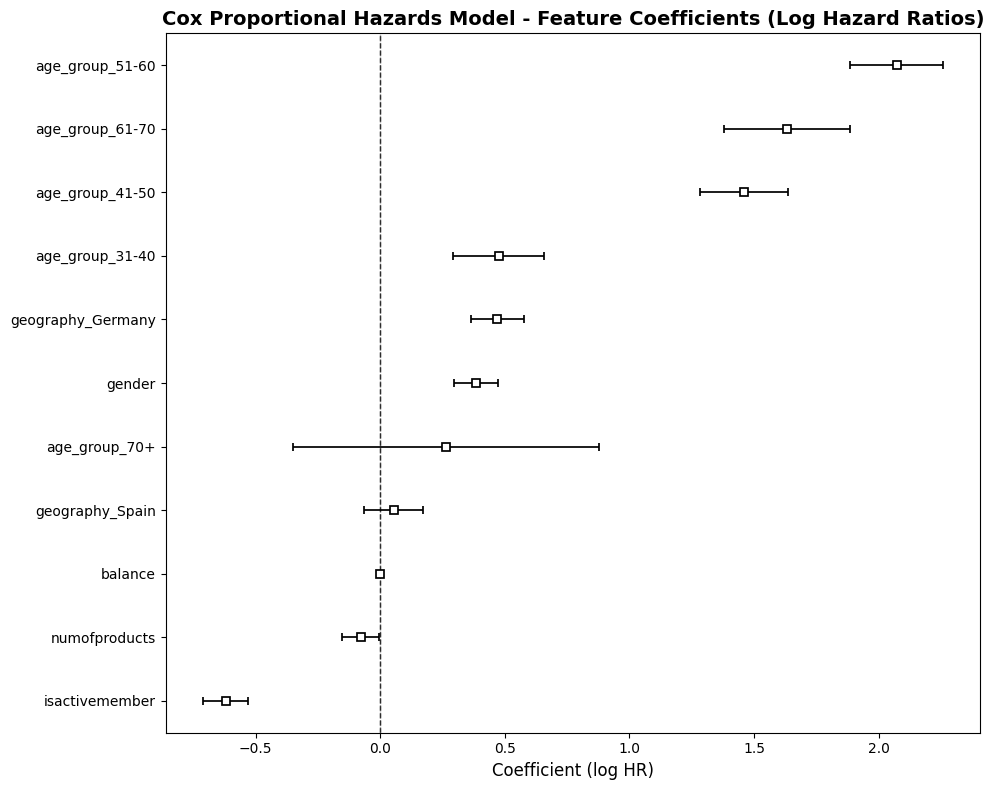

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
cph.plot(ax=ax)
ax.set_title('Cox Proportional Hazards Model - Feature Coefficients (Log Hazard Ratios)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Coefficient (log HR)', fontsize=12)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

**Interpretation:**
- **Positive coefficients** (right of 0): Increase churn risk (higher hazard)
- **Negative coefficients** (left of 0): Decrease churn risk (protective)
- **Further from 0**: Stronger effect
- **Error bars crossing 0**: Not statistically significant

### Key Findings from Cox PH Model

**Model Performance:**
- **C-index: 0.74** (Good predictive power)
- Down from 0.92 when `complain` was included, but now we can see other features' effects

**Top Risk Factors (Hazard Ratios > 1.5):**

1. **Age Group 51-60** (exp(coef) = 7.94, p < 0.005) ⚠️ HIGHEST RISK
   - Pre-retirement customers have **7.94× higher churn risk** vs baseline (18-30)
   - This lifecycle stage is the critical vulnerability window
   - Likely moving assets for retirement planning

2. **Age Group 61-70** (exp(coef) = 5.12, p < 0.005)
   - Early retirement customers have **5.12× higher churn risk** vs baseline
   - Second highest risk group

3. **Age Group 41-50** (exp(coef) = 4.31, p < 0.005)
   - Mid-life customers have **4.31× higher churn risk** vs baseline
   - Clear lifecycle pattern emerges: risk increases with age until retirement

4. **Age Group 31-40** (exp(coef) = 1.61, p < 0.005)
   - Mid-career customers have **1.61× higher churn risk** vs baseline
   - Young adults (18-30) have the best retention

5. **Germany Market** (exp(coef) = 1.60, p < 0.005)
   - German customers have **1.60× higher churn risk** vs France (baseline)
   - Market-specific issues require investigation

6. **Female Gender** (exp(coef) = 1.47, p < 0.005)
   - Female customers have **1.47× higher churn risk** vs males
   - Moderate but significant gender effect

**Protective Factors (Hazard Ratios < 1):**

1. **Active Membership** (exp(coef) = 0.54, p < 0.005) ✓ STRONGEST PROTECTIVE
   - Active members have **46% lower churn risk** (0.54× the hazard)
   - Re-activation campaigns are critical

2. **Number of Products** (exp(coef) = 0.92, p = 0.04)
   - Each additional product reduces churn by **8%** (0.92× per product)
   - BUT: EDA showed U-shape (2 products optimal, 3-4 catastrophic)
   - This linear effect masks the non-linear pattern

**Non-Significant Features:**
- **Spain Geography** (p = 0.38): No difference vs France
- **Age Group 70+** (p = 0.40): Small sample size, wide confidence intervals
- **Balance** (p < 0.005 but HR ≈ 1.00): Statistically significant but practically negligible effect

**Key Insight:**  
Age lifecycle is the dominant pattern after removing complaints. The 51-60 age group is 
the critical intervention point. Active membership is the strongest modifiable protective factor.

---

## Individual Customer Predictions

The Cox PH model allows us to predict survival probabilities and cumulative hazard 
for individual customers based on their characteristics.

In [17]:
# Select a random customer for demonstration
test_customer = regression_df.sample(1, random_state=42)
print("Selected customer profile:")
print(test_customer.T)

Selected customer profile:
                       6252
gender                 0.00
tenure                 3.00
balance            96709.07
numofproducts          2.00
isactivemember         0.00
exited                 0.00
geography_Germany      1.00
geography_Spain        0.00
age_group_31-40        1.00
age_group_41-50        0.00
age_group_51-60        0.00
age_group_61-70        0.00
age_group_70+          0.00


### Cumulative Hazard Over Time

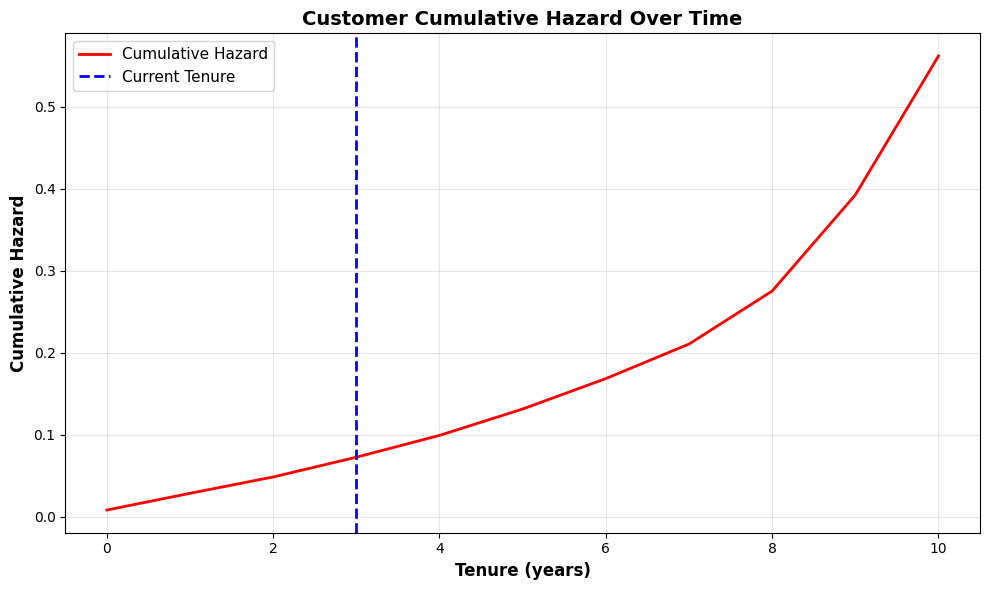

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
cph.predict_cumulative_hazard(test_customer).plot(ax=ax, color='red', linewidth=2)
plt.axvline(x=test_customer['tenure'].values[0], color='blue', linestyle='--', linewidth=2)
plt.legend(labels=['Cumulative Hazard', 'Current Tenure'], fontsize=11)
ax.set_xlabel('Tenure (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Hazard', fontsize=12, fontweight='bold')
ax.set_title('Customer Cumulative Hazard Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Survival Probability Over Time

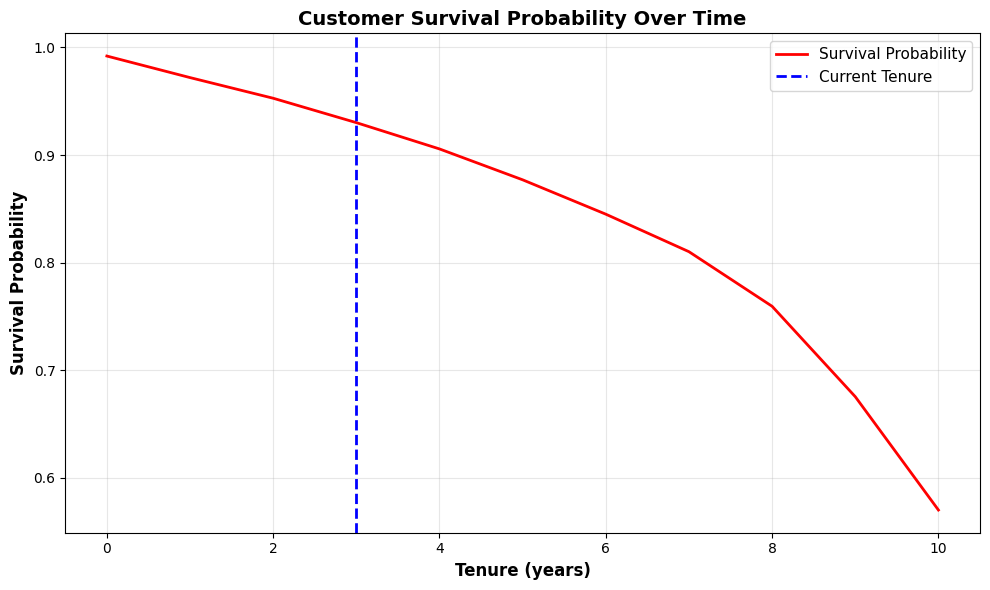

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
cph.predict_survival_function(test_customer).plot(ax=ax, color='red', linewidth=2)
plt.axvline(x=test_customer['tenure'].values[0], color='blue', linestyle='--', linewidth=2)
plt.legend(labels=['Survival Probability', 'Current Tenure'], fontsize=11)
ax.set_xlabel('Tenure (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Survival Probability', fontsize=12, fontweight='bold')
ax.set_title('Customer Survival Probability Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Saving the Model

In [20]:
import pickle

# Save the Cox PH model
with open('survivemodel.pkl', 'wb') as f:
    pickle.dump(cph, f)

print("✓ Model saved to 'survivemodel.pkl'")

✓ Model saved to 'survivemodel.pkl'


---

## Customer Lifetime Value (CLV) Estimation

### Methodology

Customer Lifetime Value can be estimated by multiplying the customer's account balance
(or expected revenue stream) by their expected remaining lifetime.

We'll use the survival function to calculate expected lifetime, defining "churn threshold"
as when survival probability drops below 10% (conservative estimate).

In [21]:
def calculate_expected_lifetime(cph, customer_data, threshold=0.10):
    """
    Calculate expected customer lifetime based on survival function.
    
    Parameters
    ----------
    cph : CoxPHFitter
        Fitted Cox PH model
    customer_data : pd.DataFrame
        Customer feature vector
    threshold : float
        Survival probability threshold to consider as "churned" (default: 0.10)
        
    Returns
    -------
    float
        Expected lifetime in years
    """
    # Get survival function
    surv_func = cph.predict_survival_function(customer_data)
    
    # Find time when survival drops below threshold
    surv_curve = surv_func.iloc[:, 0]
    
    # If survival never drops below threshold, use max tenure
    churned_times = surv_curve[surv_curve < threshold]
    if len(churned_times) == 0:
        expected_lifetime = surv_curve.index.max()
    else:
        expected_lifetime = churned_times.index.min()
    
    return expected_lifetime

In [23]:
# Calculate CLV for sample customer
test_customer_lifetime = calculate_expected_lifetime(cph, test_customer, threshold=0.10)
test_customer_balance = test_customer['balance'].values[0]
test_customer_tenure = test_customer['tenure'].values[0]

# Determine age group from dummy variables (for display purposes)
age_group_cols = [col for col in test_customer.columns if col.startswith('age_group_')]
active_age_group = 'Baseline (18-30)'  # Default if no age_group column is 1
for col in age_group_cols:
    if test_customer[col].values[0] == 1:
        active_age_group = col.replace('age_group_', '')
        break

print(f"{'='*80}")
print(f"CUSTOMER LIFETIME VALUE ESTIMATION")
print(f"{'='*80}")
print(f"Customer Profile:")
print(f"  - Age Group: {active_age_group}")
print(f"  - Current Tenure: {test_customer_tenure:.1f} years")
print(f"  - Account Balance: ${test_customer_balance:,.2f}")
print(f"\nLifetime Prediction:")
print(f"  - Expected Remaining Lifetime: {test_customer_lifetime:.2f} years")
print(f"  - Total Expected Tenure: {test_customer_tenure + test_customer_lifetime:.2f} years")
print(f"\nSimplified CLV (Balance × Remaining Lifetime):")
print(f"  - Estimated CLV: ${test_customer_balance * test_customer_lifetime:,.2f}")
print(f"{'='*80}")

CUSTOMER LIFETIME VALUE ESTIMATION
Customer Profile:
  - Age Group: 31-40
  - Current Tenure: 3.0 years
  - Account Balance: $96,709.07

Lifetime Prediction:
  - Expected Remaining Lifetime: 10.00 years
  - Total Expected Tenure: 13.00 years

Simplified CLV (Balance × Remaining Lifetime):
  - Estimated CLV: $967,090.70


**Note:** This is a simplified CLV calculation. A more sophisticated model would incorporate:
- Expected revenue streams (not just balance)
- Discount rates for time value of money
- Customer acquisition costs
- Operating costs per customer
- Cross-sell/upsell opportunities

---

## Summary & Key Findings

### Survival Analysis Highlights:

1. **Complaint Status** - Most critical predictor (not in Cox model)
   - Customers who complain have near-certain churn (99.5% churn rate)
   - exp(coef) = 2,652× when included in model - too dominant to model with other features
   - Survival curves are dramatically different (highly significant log-rank test)
   - **Action:** Proactive complaint prevention is priority #1

2. **Age Lifecycle Pattern** - Dominant pattern in Cox PH model
   - **51-60 age group**: 7.94× higher churn risk (HIGHEST RISK)
   - **61-70 age group**: 5.12× higher churn risk
   - **41-50 age group**: 4.31× higher churn risk
   - **31-40 age group**: 1.61× higher churn risk
   - **18-30 baseline**: Best retention (reference group)
   - Clear lifecycle vulnerability: risk peaks during pre-retirement (51-60)
   - **Action:** Target 51-60 age group with specialized retirement planning offerings

3. **Active Member Status** - Strongest protective factor (modifiable)
   - Inactive members have 1.85× higher churn risk (1/0.54)
   - Active membership reduces risk by 46%
   - Clear separation in survival curves
   - **Action:** Re-activation campaigns for inactive members are critical

4. **Geography** - Market-specific effect
   - Germany: 1.60× higher churn risk vs France
   - Spain: No significant difference vs France
   - **Action:** Investigate and address systemic issues in German market

5. **Gender** - Moderate demographic effect
   - Females: 1.47× higher churn risk vs males
   - **Action:** Consider gender-specific retention strategies

6. **Number of Products** - Non-linear pattern (U-shape)
   - Cox model shows 8% risk reduction per product (linear assumption)
   - BUT: EDA/Log-rank tests reveal U-shape: 2 products optimal (7.6% churn), 3-4 catastrophic (100%)
   - Cox model's linear effect masks this non-linearity
   - **Action:** Avoid pushing 3+ products; optimize at 2 products per customer

### Cox PH Model Performance:

- **C-index: 0.74** (Good predictive power)
- Provides individual-level churn risk predictions
- Quantifies hazard ratios for each feature
- Enables targeted retention interventions
- Supports customer lifetime value estimation
- Model excludes `complain` (too dominant) and `age` (multicollinearity with age_group)

### Top 3 Actionable Recommendations:

1. **Prevent complaints** - Proactive issue resolution before escalation (99.5% churn if complaint filed)
2. **Target pre-retirement customers (51-60)** - Specialized offerings for highest-risk lifecycle stage
3. **Re-activate inactive members** - Engagement campaigns for strongest modifiable protective factor
4. **Investigate Germany market** - Address market-specific retention issues
5. **Product optimization** - Promote 2-product sweet spot, avoid over-selling

---

**✓ Survival Analysis Complete! Ready for predictive modeling in the next notebook.**